
# <center>Eclipse Photon Dose Calculation with PortPy Optimization</center>

This guide explains how to perform **photon dose calculation** and generate **PortPy-compatible data** for **custom patients** which are not part of the PortPy dataset. This process is **only for Eclipse TPS users** and requires Varian’s photon dose calculation module.

Follow the steps below to prepare your data and run dose calculation using Eclipse.

---

### **1. Download the Photon Dose Calculation Module**
Download the required module from Varian's GitHub repository under release tab: [CalculateInfluenceMatrix](https://github.com/Varian-MedicalAffairsAppliedSolutions/MAAS-DoseInfluenceMatrix/tree/main) 

### **2. Prepare Your Plan in Eclipse**
Before running dose calculation, you must set up your plan correctly in Eclipse.

#### **IMRT vs. VMAT Plans**
- The photon dose calculation module **only supports static IMRT beams**.  
- If you have a **VMAT plan**, you can convert it to discrete IMRT beams. 
  Example: If your VMAT plan has an arc from **0° to 180°**, please create a plan with discrete beams spaced at some interval e.g. 4° intervals. This notebook gives an example of IMRT optimization. For VMAT optimzation, please follow optimization steps in [vmat_scp_tutorial.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/vmat_scp_tutorial.ipynb)

#### **Modify Dose Calculation Box Volume**
By default, the dose calculation box covers the entire CT scan. **Reduce the calculation box volume** to avoid computational issues:  
- In the **Z-direction**, limit the box to **PTV ± 3 cm**.

![Reset Calc Box](../images/reset_calc_box.png)  
<img src="../images/reset_calc_box_adjust.png" alt="Adjust Calc Box" width="500"> 

#### **Standardize Structure Names**
To ensure compatibility with PortPy, structure names in Eclipse must match PortPy’s clinical config file format.  
- Example: Rename **"Lung-Left"** to **"Lung_L"**.
  
Alternatively, you can manually map Eclipse structure names to PortPy names during data processing as shown below in notebook.

### **3. Run Photon Dose Calculation**
Once your plan is set up, run the dose calculation using one of the following methods:

#### **3.1. Using the Plugin (GUI Method)**
For users unfamiliar with command-line scripting, the plugin provides a **graphical interface** for dose calculation.

##### **Steps:**
1. Navigate to the release [tab](https://github.com/Varian-MedicalAffairsAppliedSolutions/MAAS-DoseInfluenceMatrix/releases) tab for dose calculation module and download the latest version of CalculateInfluenceMatrix  
2. Modify the config file:  
   - Edit CalculateInfluenceMatrix.esapi.dll.config.  
   - Set `Photon_OutputRootFolder` to your preferred output directory.  You can also modify `BeamletSizeX` and `BeamletSizeY` for choosing the beamlet size in X and Y direction. Please modify the `Photon_EclipseVolumeDoseCalcModel` based on your dose calculation version available at your institution.
3. In Eclipse:
   - Open your patient plan (e.g., **PortPy_Plan**).  
   - Navigate to **Tools → Scripts → Change Folder**.  
   - Change the path to downloaded folder from release and click **Open**.  
   - Select **CalculateInfluenceMatrix.esapi.dll** and click **Run**
   - (Optional) Add the plugin to **Favorites** for quicker access.  

**Output:** PortPy-compatible data will be saved in the `OutputRootFolder` specified in the config file.


#### **3.2. Using the Executable (Command-Line Method)**
For users comfortable with command-line execution.

##### **Steps:**
1. Navigate to the release [tab](https://github.com/Varian-MedicalAffairsAppliedSolutions/MAAS-DoseInfluenceMatrix/releases) tab for dose calculation module and download the latest version of CalculateInfluenceMatrix.  
2. Modify the config file:
   - Edit CalculateInfluenceMatrix.exe.config.  
   - Set `Photon_OutputRootFolder` to your preferred output directory. You can also modify `Photon_BeamletSizeX` and `Photon_BeamletSizeY` for choosing the beamlet size in X and Y direction. Please modify the `Photon_EclipseVolumeDoseCalcModel` based on your dose calculation version available at your institution.
     
3. Run the following command in a terminal or command prompt:  
   ```bash
   CalculateInfluenceMatrix.exe <patient_mrn> <course_name> <plan_name>

##### This example demonstrates the following main functionalities of portpy.photon module:


1. Accessing the curated portpy data
    (DataExplorer class)

2. Creating a simple IMRT plan through integration with [CVXPy](https://www.cvxpy.org/) package
    (Plan class, Optimization class)

3. Visualising the plan (e.g., dose distribution, DVH)
   (Visualization class)

4. Evaluating the plan (e.g., max/mean/DVH points, established clinical metrics)
    (Evaluation class)

5. Saving the plan and solution for future uses
    (Utils)

### 1) Accessing the portpy data created using above method (DataExplorer class)



In [1]:
import sys
sys.path.append('..')

In [2]:
# If you're running PortPy for the first time, you need to install the requirements 
# !pip install -r ..\requirements.txt

In [38]:
import portpy.photon as pp
import numpy as np
import os
from copy import deepcopy
import scipy

In [60]:
# specify the patient data location .
data_dir = r'../OutputRootFolder/patient_mrn'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)

In [7]:
# mention the plan name for which photon dose calculation module was ran to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Test_Plugin_2'
# display the data of the patient 
# user can get the results back in the panda dataframe format by using the arguments 'return_beams_df' and 'return_structs_df'
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()
# the following table shows the beams for which the data has been extracted for the specified patient

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,01,175.0,0.0,0.0,STATIC,6X,Both,"{'x_mm': 47.7960052, 'y_mm': -1.96387279, 'z_m...",,445HET1
1,02,150.0,0.0,0.0,STATIC,6X,Both,"{'x_mm': 47.7960052, 'y_mm': -1.96387279, 'z_m...",,445HET1
2,03,120.0,0.0,0.0,STATIC,6X,Both,"{'x_mm': 47.7960052, 'y_mm': -1.96387279, 'z_m...",,445HET1
3,04,90.0,0.0,0.0,STATIC,6X,Both,"{'x_mm': 47.7960052, 'y_mm': -1.96387279, 'z_m...",,445HET1
4,05,60.0,0.0,0.0,STATIC,6X,Both,"{'x_mm': 47.7960052, 'y_mm': -1.96387279, 'z_m...",,445HET1


In [8]:
structs_df.head()
# the following table shows the list of structures for the specified patient

,name,volume_cc
0,gtv-3,8.095892
1,Spinal-Cord,48.445696
2,Esophagus,49.752164
3,Heart,982.544896
4,BODY,25338.097411


In [9]:
# run below function to add ct to dose voxel map to PortPy data
pp.create_ct_dose_voxel_map(os.path.join(data_dir, data.patient_id))

starting python code..
Creating ct to dose voxel map..


In [51]:
# If the list of beams are not provided, it uses the all the beams in the Eclipse plan
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data, load_inf_matrix_full=True)

In [16]:
# load structures from the data
structs = pp.Structures(data)

In [23]:
# # create a dictionary called map structures which map dicom structure name to standard structure name used in PortPy clinical criteria.
# Eg. 'Lung-Left' in dicom is mapped to 'LUNG_L' structure used in PortPy clinical criteria template
# User needs to change it based on their patient specific structure names
map_structures = {'PTV': 'PTV',
                  'EL_Skin': 'SKIN',
                  'Lungs_NOT_GTV': 'LUNGS_NOT_GTV',
                  'Lung-Left': 'LUNG_L',
                  'Lung-Right': 'LUNG_R',
                  'Heart': 'HEART',
                  'GTV-1': 'GTV',
                  'Esophagus': 'ESOPHAGUS',
                  'Spinal-Cord': 'CORD',
                  'BODY': 'BODY'}
dicom_structure_names = map_structures.keys()
for ind, s in enumerate(structs.get_structures()):
    if s in dicom_structure_names:
        structs.structures_dict['name'][ind] = map_structures[s].upper()

 #### Clinical Protocols
In order to create an IMRT plan, we first need to specify a protocol which includes the disease site, the prescribed dose for the PTV, the number of fractions, and the radiation dose thresholds for OARs. These information are stored in .json files which can be found in a directory named "config_files". An example of such a file is 'Lung_2Gy_30Fx.json'. Here's how you can load these files:
 

In [26]:
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

#### Optimization Problem Formulation
The next step is to fromulate an optimization problem with an objective function measuring various plan quality metrics, along with a set of non-negotiable constraints often encapsulated as max/mean outlined in the clinical protocol. 

In [31]:
protocol_name = 'Lung_2Gy_30Fx'
# Loading hyper-parameter values for optimization problem
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Creating optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Loading influence matrix
inf_matrix = pp.InfluenceMatrix(structs=structs, beams=beams, is_bev=True, is_full=True)

Creating optimization structures.. It may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading full influence matrix..
Done


#### Truncated influence matrix
The dose influence matrix plays a pivotal role in the optimization process, but it can also pose significant computational challenges when solving optimization problems. The original influence matrix is dense and handling it can be computationally demanding. For this reason, we opt to load a truncated version of the matrix to run the optimization. We truncate the matrix by cutting off the value smaller than 1% of maximum of influence matrix . However, this truncation introduces discrepancies between the optimized dose and the final dose. Please refer to the PortPy tutorial on [imrt_tps_import](https://github.com/PortPy-Project/PortPy/blob/master/examples/imrt_tps_import.ipynb) for guidance on how to address this issue for photon version. 


In [41]:
# copy the original matrix for future use
A = deepcopy(inf_matrix.A)
S = np.where(A > np.max(A) * 0.01, A, 0) # sparsify the matrix
S = scipy.sparse.csr_matrix(S)
inf_matrix.A = S # modify the dense matrix with sparse in influenc matrix object

### 2) Optimizing a IMRT plan using CVXPy (Plan class, Optimization class)
We use [CVXPy](https://www.cvxpy.org/), a Python-embedded modeling language, to solve the resulting optimization problems. CVXPy offers a high-level programming interface for easy prototyping and seamless access to several open-source (e.g., ECOS, OSQP, SCS) and commercial optimization engines (e.g., MOSEK, GUROBI, CPLEX). Most commercial engines offer free licenses for research and academic purposes, however, it is up to users to secure these licenses.

In our experiments, we found the commercial solver MOSEK to be highly efficient in solving the IMRT optimization problems. You can obtain the MOSEK license file by applying using an .edu account [here](https://www.mosek.com/products/academic-licenses/). The license file should be placed in the directory C:\Users\username\mosek. If a license is not available, you may try open-source or free solvers like SCS or ECOS. Please refer to the CVXPy documentation for more information about its various solvers.


In [43]:
# create a plan using ct, structures, beams and influence matrix, and clinical criteria
my_plan = pp.Plan(structs = structs, beams = beams, inf_matrix = inf_matrix, clinical_criteria=clinical_criteria)

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# solve the cvxpy problem using Mosek
sol = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 65.47579908807353
Elapsed time: 33.54785704612732 seconds


### 3) Visualizing the plan (Visualization class)

<Axes: title={'center': 'Test_Plugin_2'}, xlabel='Dose (Gy)', ylabel='Fractional Volume (%)'>

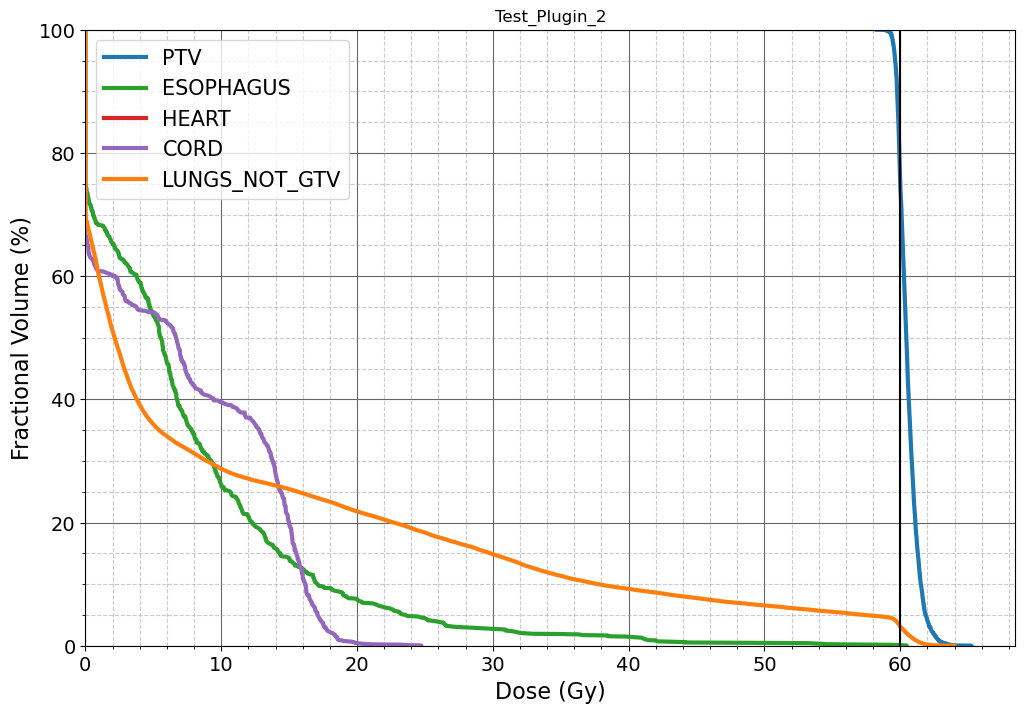

In [44]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNGS_NOT_GTV']

# plot dvh for the above structures
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, title=data.patient_id)


### 4) Evaluating the plan (Evaluation class)
The Evaluation class offers a set of methods for quantifying the optimized plan. If you need to compute individual dose volume metrics, you can use methods such as *get_dose* or *get_volume*. Furthermore, the class also facilitates the assessment of the plan based on a collection of metrics, such as mean, max, and dose-volume histogram (DVH), as specified in the clinical protocol. This capability is demonstrated below


In [46]:
# visualize plan metrics and compare them against the clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=sol, clinical_criteria=clinical_criteria)
# The Evaluation class also has methods to extract different DVH metrics (e.g., get_dose(sol, struct, volume_per), get_volume(sol: struct dose_value_gy)))


,constraint,structure_name,Limit,Goal,Plan Value
0,max_dose,GTV,69.0Gy,66.0Gy,62.61
1,max_dose,PTV,69.0Gy,66.0Gy,65.21
2,max_dose,ESOPHAGUS,66.0Gy,,60.47
3,mean_dose,ESOPHAGUS,34.0Gy,21.0Gy,7.29
4,V(60.0Gy),ESOPHAGUS,17.0%,,0.09
5,max_dose,HEART,66.0Gy,,0.00
6,mean_dose,HEART,27.0Gy,20.0Gy,0.00
7,V(30.0Gy),HEART,50.0%,,0.00
8,V(30.0Gy),HEART,,48.0%,0.00
9,max_dose,LUNG_L,66.0Gy,,63.97


### 5) Saving and loading the plan for future use (utils)


In [13]:
# Comment/Uncomment these lines to save and load the pickle file for plans and optimal solution from the directory
pp.save_plan(my_plan, plan_name='my_plan.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_optimal_sol(sol, sol_name='sol.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# my_plan = pp.load_plan(plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# sol = pp.load_optimal_sol(sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))